# Template análise de texto

Este notebook contém um **template completo** para análise de textos, incluindo pré-processamento, análise de sentimentos, geração de nuvem de palavras e clustering hierárquico.

🔹 **Funcionalidades:**
- **Limpeza de texto**: remoção de stopwords e caracteres especiais.
- **Análise de Sentimentos**: usa um léxico (`OpLexicon`) para calcular um score.
- **Geração de Nuvem de Palavras**: visualização das palavras mais frequentes.
- **Clusterização Hierárquica**: organização das palavras mais comuns em um dendrograma.
- **Geração de Relatório HTML** com insights visuais.

🔹 **Bibliotecas Utilizadas:**
- `pandas`, `numpy`, `random` → Manipulação de dados.
- `nltk` → Tokenização e remoção de stopwords.
- `wordcloud` → Geração de nuvem de palavras.
- `matplotlib` → Visualização de dados.
- `sklearn.feature_extraction.text` → Vetorização de palavras.
- `scipy` → Cálculo de distâncias para clustering.
- `base64` e `io.BytesIO` → Codificação de imagens para relatório.

In [12]:
#### Passo 0: Instalar o Pandas e o OpenPyXL
#!pip install pandas openpyxl

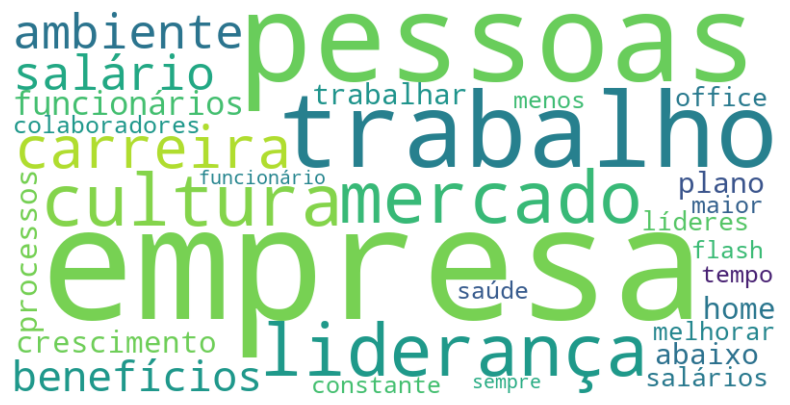

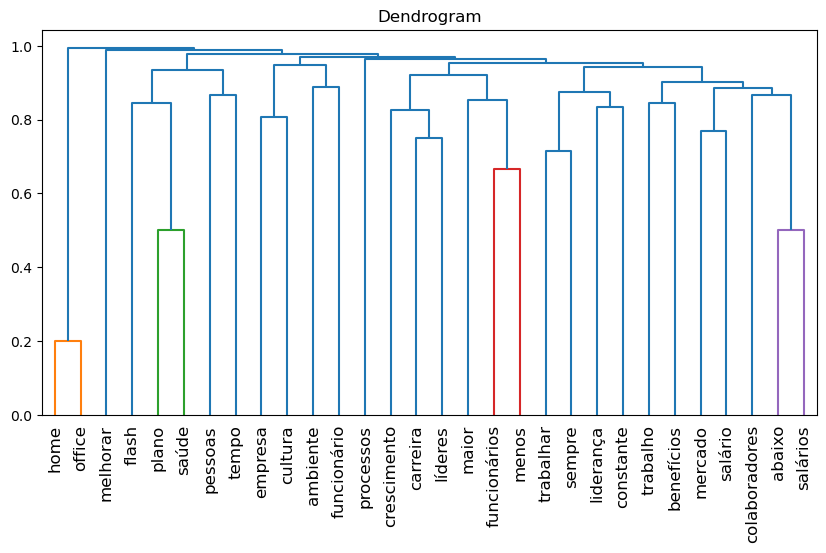

In [24]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import base64
from io import BytesIO
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage
import re

# Fixando a seed para consistência nos resultados
np.random.seed(42)
random.seed(42)

# Função para carregar o léxico de polaridade
def carregar_op_lexicon(caminho_arquivo):
    """Carrega um léxico de palavras e suas polaridades para análise de sentimento."""
    lexico = {}
    with open(caminho_arquivo, 'r', encoding='utf-8') as arquivo:
        for linha in arquivo:
            partes = linha.strip().split(',')
            if len(partes) >= 3:
                palavra, _, polaridade, _ = partes
                lexico[palavra] = int(polaridade)
    return lexico

op_lexicon = carregar_op_lexicon('lexico_v3.0.txt')

# Carregar base de dados
df = pd.read_excel('base.xlsx', engine='openpyxl')

# Stopwords manuais (sem `nltk`)
stop_words = {
    "de", "a", "o", "que", "e", "do", "da", "em", "um", "para", "é", "com", "não",
    "uma", "os", "no", "se", "na", "por", "mais", "as", "dos", "como", "mas", "foi",
    "ao", "ele", "das", "tem", "à", "seu", "sua", "ou", "ser", "quando", "muito",
    "há", "nos", "já", "está", "eu", "também", "só", "pelo", "pela", "até", "isso",
    "entre", "era", "depois", "sem", "mesmo", "aos", "ter", "seus", "quem", "nas",
    "me", "esse", "eles", "estão", "você", "tinha", "foram", "essa", "num", "nem",
    "suas", "meu", "às", "minha", "têm", "numa", "pelos", "elas", "havia", "seja",
    "qual", "será", "nós", "tenho", "lhe", "deles", "essas", "esses", "pelas", "este",
    "fosse", "dele", "tu", "te", "vocês", "vos", "lhes", "meus", "minhas", "teu",
    "tua", "teus", "tuas", "nosso", "nossa", "nossos", "nossas", "dela", "delas",
    "esta", "estes", "estas", "aquele", "aquela", "aqueles", "aquelas", "isto",
    "aquilo", "aqueles", "pro", "pra", "vejo", "ainda", "dia", "ponto", "todos",
    "bom", "bem", "são", "fazer", "todo", "fazendo", "apenas", "falta", "parte",
    "pois"
}

# Função de limpeza de texto SEM `word_tokenize`
def clean_text(text):
    """Limpa o texto, removendo stopwords e caracteres não alfabéticos."""
    if not isinstance(text, str):
        return ""
    
    # Removendo caracteres especiais
    texto = re.sub(r'[^\w\s]', '', text, flags=re.UNICODE).lower()
    
    # Tokenização alternativa usando split()
    palavras = texto.split()
    
    # Removendo stopwords
    palavras_filtradas = [palavra for palavra in palavras if palavra not in stop_words and palavra.isalpha()]
    
    return " ".join(palavras_filtradas)

df['Texto'] = df['Texto'].apply(clean_text)

# Função de análise de sentimento SEM `word_tokenize`
def analisar_sentimento(texto, op_lexicon):
    """Calcula o score de sentimento baseado no léxico."""
    palavras = texto.split()  # Alternativa sem `word_tokenize`
    return sum(op_lexicon.get(palavra, 0) for palavra in palavras)

df['sentiment_score'] = df['Texto'].apply(analisar_sentimento, args=(op_lexicon,))
media_score = round(df['sentiment_score'].mean(), 2)

# Função para converter imagens para base64
def image_to_base64(plt_figure):
    buf = BytesIO()
    plt_figure.savefig(buf, format='png')
    buf.seek(0)
    return base64.b64encode(buf.getvalue()).decode('utf-8')

# Função para gerar a nuvem de palavras
def save_wordcloud(texto):
    """Gera uma nuvem de palavras baseada na frequência."""
    palavras = texto.split()
    contagem_palavras = Counter(palavras)
    palavras_top = dict(contagem_palavras.most_common(30))
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(palavras_top)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    
    return image_to_base64(plt)

# Função para gerar o dendrograma
def save_dendrogram(textos):
    """Cria um dendrograma hierárquico baseado na similaridade entre palavras."""
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(textos)
    terms = vectorizer.get_feature_names_out()
    
    term_freq = np.asarray(X.sum(axis=0)).ravel()
    frequent_terms = [term for term, freq in sorted(zip(terms, term_freq), key=lambda x: x[1], reverse=True)[:30]]
    
    X_top = CountVectorizer(vocabulary=frequent_terms).fit_transform(textos)
    distance_matrix = pdist(X_top.toarray().T, 'jaccard')
    linkage_matrix = linkage(distance_matrix, 'average')
    
    plt.figure(figsize=(10, 5))
    dendrogram(linkage_matrix, labels=frequent_terms, leaf_rotation=90, leaf_font_size=12)
    plt.title("Dendrogram")
    
    return image_to_base64(plt)

wordcloud_image = save_wordcloud(' '.join(df['Texto'].tolist()))
dendrogram_image = save_dendrogram(df['Texto'].tolist())

# Criando o relatório HTML
html_content = f"""
<html>
<head><title>Relatório de Análise</title></head>
<body>
<h1>Média de Score de Sentimento: {media_score}</h1>
<h1>Nuvem de Palavras</h1>
<img src="data:image/png;base64,{wordcloud_image}" alt="Wordcloud">
<h1>Dendrograma de Clustering</h1>
<img src="data:image/png;base64,{dendrogram_image}" alt="Dendrogram">
</body>
</html>
"""

with open("report.html", "w") as file:
    file.write(html_content)
